# Task-2: Movie Ratings Prediction

## Importing Libraries

In [47]:
#General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score

In [48]:
import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [50]:
df = pd.read_csv("IMDb Movies India.csv", encoding='cp1252')

In [51]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


## Data Preprocessing

### Missing value check

In [55]:
missingval=df.isna().sum()

In [56]:
missingval[missingval>0]

Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

### Cleaning "Name"

In [58]:
df['Name'].replace(['', ' ', 'NaN', 'nan'], np.nan, inplace=True)

In [59]:
df=df.dropna(subset=["Name"])

<b>Dropping rows with missing names as, movies with no names are probably corrupted data or won't be able to contribute to the model in any proper way.

### <b>Cleaning "Year":

In [62]:
df['Year'].replace(['', ' ', 'NaN', 'nan'], np.nan, inplace=True)

In [63]:
df=df.dropna(subset=["Year"])

In [64]:
df['Year'] = df['Year'].str.extract(r'(\d+)')
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

### Cleaning "Genre"

In [66]:
df=df.dropna(subset=["Genre"])

### Converting "Duration"

In [68]:
df['Duration'] = df['Duration'].str.extract(r'(\d+)')  
df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')  

 Grouping movies by genre, then replacing NaN values by genre-wise median:

In [70]:
df['Duration'] = df.groupby('Genre')['Duration'].transform(lambda x: x.fillna(x.median()))

In [71]:
df['Duration'].fillna(df["Duration"].median(), inplace=True)

### Cleaning "Votes"

In [73]:
df['Votes']=pd.to_numeric(df['Votes'], errors='coerce')  
df["Votes"]=df["Votes"].fillna(df["Votes"].median())

### Cleaning "Ratings"

 Since Rating is response variable, we remove rows with missing ratings:

In [76]:
df=df.dropna(subset=["Rating"])

### Cleaning Director and Actor columns

In [78]:
df[["Director","Actor 1","Actor 2","Actor 3"]]=df[["Director","Actor 1","Actor 2","Actor 3"]].fillna("Unknown")

## EDA

### Numeric columns

In [81]:
df[['Duration', 'Votes', 'Rating']].describe()

,Duration,Votes,Rating
count,7817.000000,7817.000000,7817.000000
mean,131.786619,107.365358,5.839568
std,23.806449,180.329433,1.381472
min,21.000000,5.000000,1.100000
25%,120.000000,17.000000,4.900000
50%,133.000000,36.000000,6.000000
75%,145.000000,92.000000,6.800000
max,321.000000,999.000000,10.000000


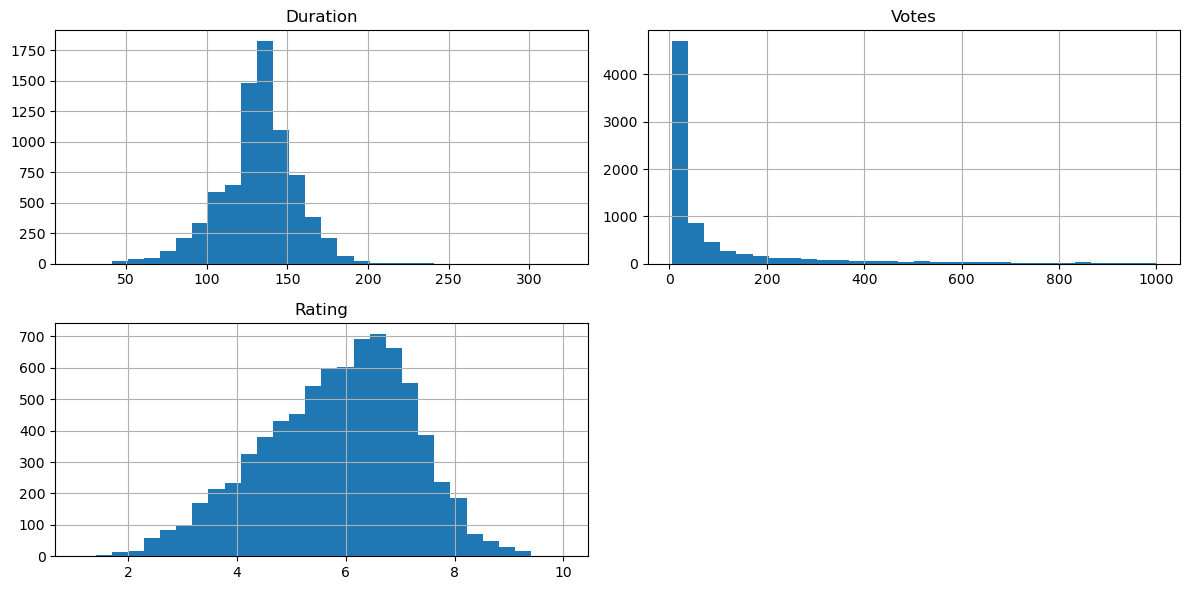

In [82]:
df[['Duration', 'Votes', 'Rating']].hist(bins=30, figsize=(12,6))
plt.tight_layout()
plt.show()

We can see that Duration and Rating are more or less normal in nature, but Votes is higly positively skewed. We may have to check for outliers.

<b>Checking for outiers in "Votes"

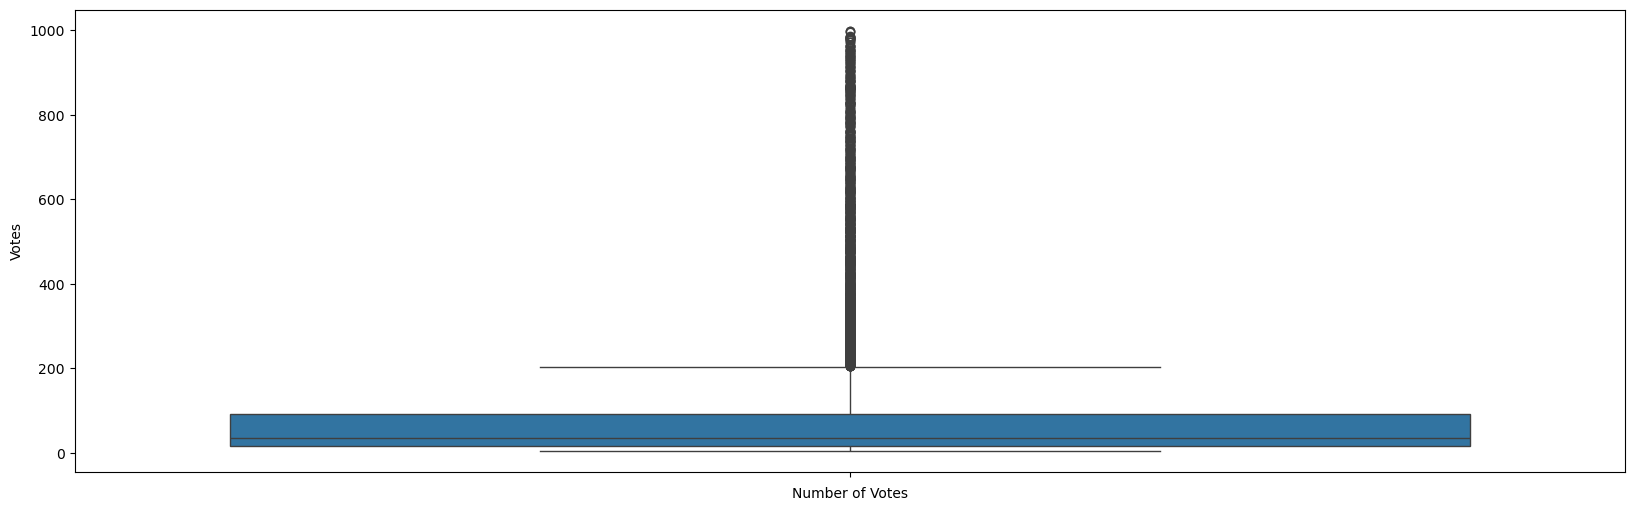

In [85]:
plt.figure(figsize=(20, 6))
sns.boxplot(df["Votes"])  
plt.xlabel("Number of Votes")
plt.show()

Lot of outliers present but before dropping outliers, we check if the extreme values are unnantural or naturally occuring

In [87]:
df.sort_values(by="Votes", ascending=False).head(15)[["Name", "Year", "Votes", "Rating"]]


,Name,Year,Votes,Rating
12569,Satyam Shivam Sundaram: Love Sublime,1978,999.0,7.1
5663,Hera Pheri,1976,998.0,6.8
7930,Kurukshetra,2000,996.0,6.0
3961,Dishkiyaoon,2014,986.0,5.2
7083,Kadvi Hawa,2017,985.0,8.1
6241,Ittefaq,1969,985.0,7.4
9822,Naam,1986,984.0,7.5
12,100 Days,1991,983.0,6.5
2612,Bumboo,2012,982.0,6.0
2453,Blood Money,2012,981.0,5.0


We can confirm that these are the older movies that have had enough time to be rated by a lot of people. Thus these high vote values are normal and not unnatural outliers.

So, we dont drop outliers, but we use log transformation to compress values and reduce skewness

In [89]:
df["Log Votes"]=np.log1p(df["Votes"])

#### Correlation Heatmap

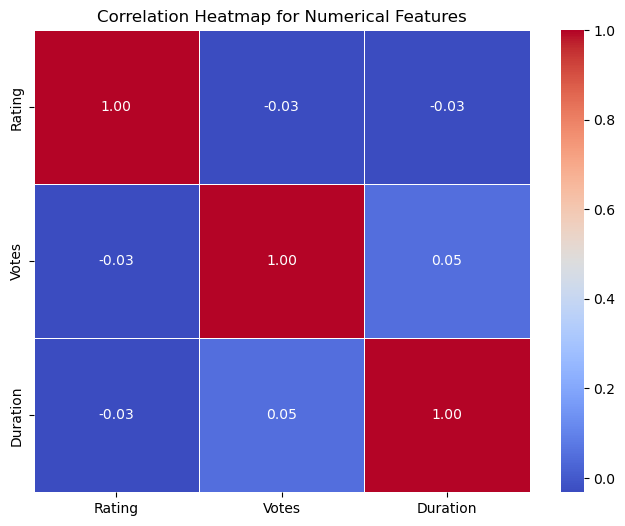

In [91]:
num_cols = ['Rating', 'Votes', 'Duration']
correlation_matrix = df[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap for Numerical Features')
plt.show()


### Categorical columns

<b>"Genre"

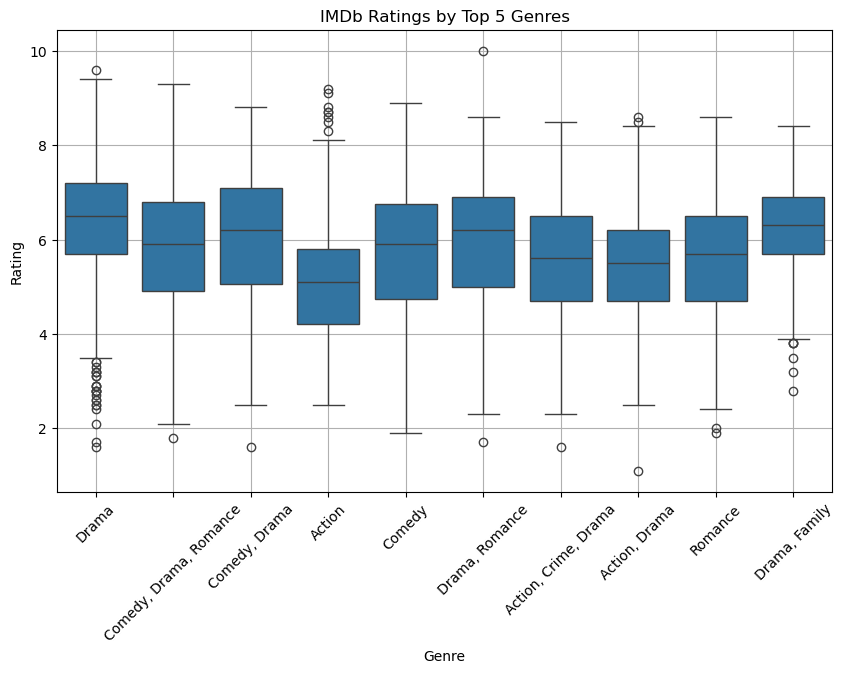

In [94]:
top_genres = df['Genre'].value_counts().head(10).index
plt.figure(figsize=(10,6))
sns.boxplot(data=df[df['Genre'].isin(top_genres)], x='Genre', y='Rating')
plt.title('IMDb Ratings by Top 5 Genres')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Excluding some exceptionally good or bad movies, "Drama" genre has highest coinsistent ratings

<b>Director and Actors

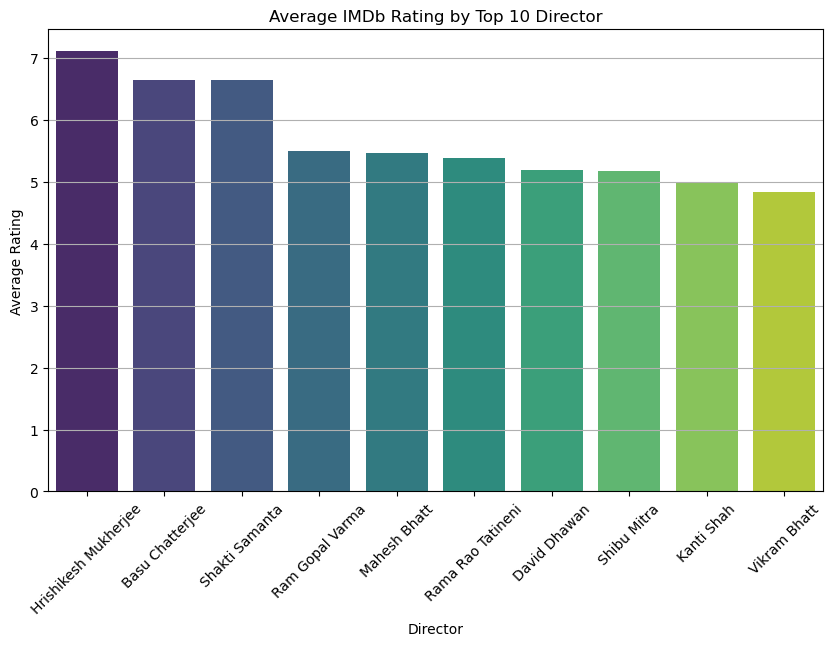

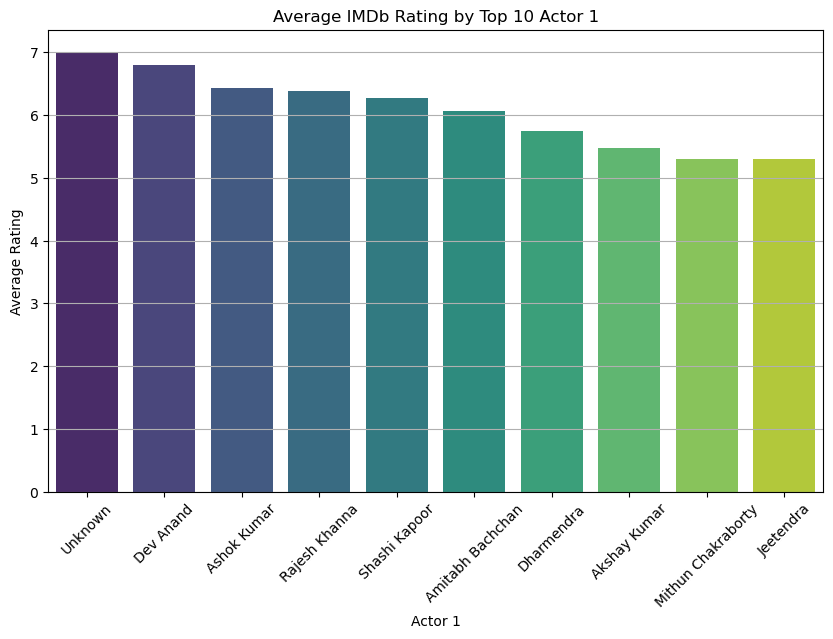

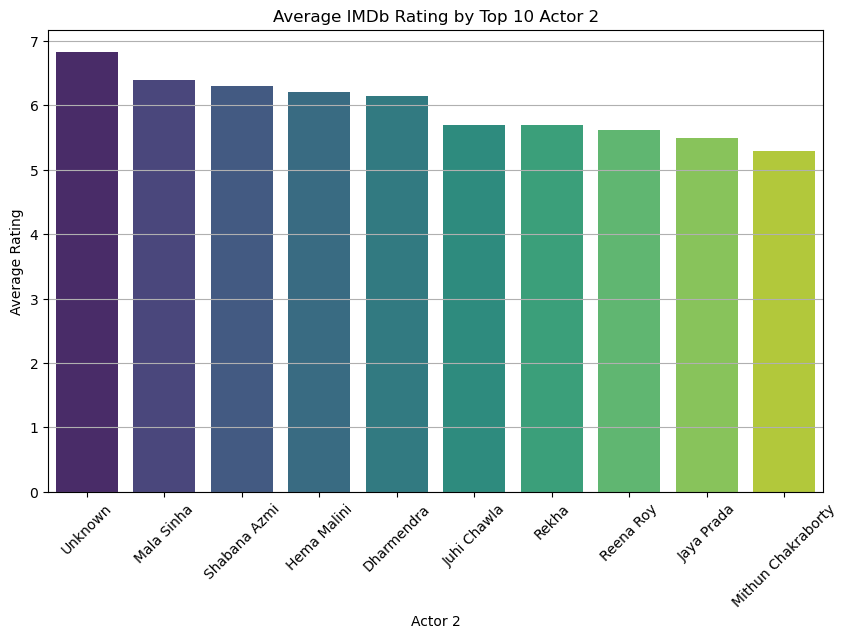

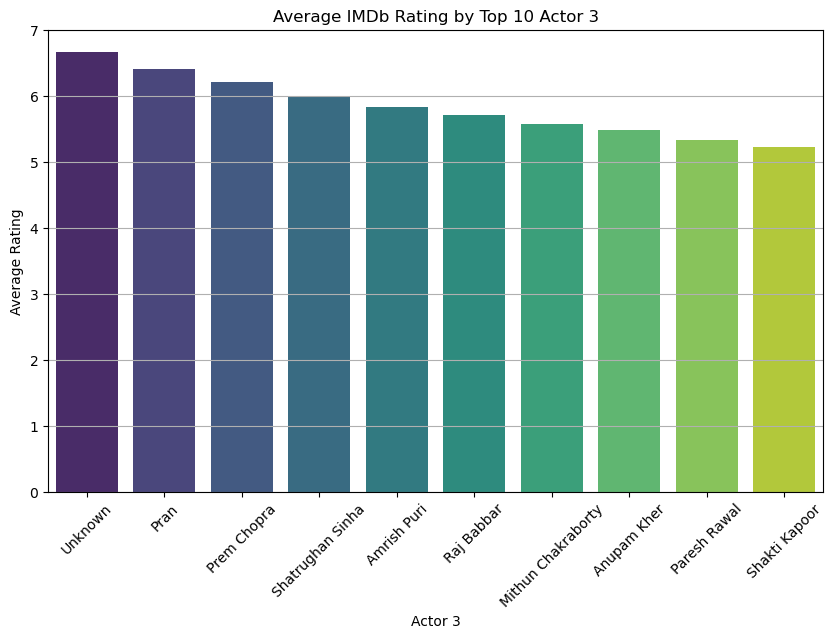

In [97]:
def plot_avg_rating_bar(column, top_n=10):
    top_items = df[column].value_counts().head(top_n).index
    avg_ratings = df[df[column].isin(top_items)].groupby(column)['Rating'].mean().sort_values(ascending=False)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x=avg_ratings.index, y=avg_ratings.values, palette='viridis')
    plt.title(f'Average IMDb Rating by Top {top_n} {column}')
    plt.ylabel('Average Rating')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

# Plotting for each
plot_avg_rating_bar("Director")
plot_avg_rating_bar("Actor 1")
plot_avg_rating_bar("Actor 2")
plot_avg_rating_bar("Actor 3")


We can see that the actor infomation of the highest rated films have been lost. We check for that:

In [99]:
# Sort movies by rating and filter for movies before 2000
top_rated_old_movies = df[df['Year'].astype(str).str.extract('(\d{4})').astype(int)[0] < 2000]
top_rated_old_movies_sorted = top_rated_old_movies.sort_values(by='Rating', ascending=False)

# Check for missing actor info in top-rated old movies
top_rated_old_movies_sorted[['Name', 'Year', 'Rating', 'Actor 1', 'Actor 2', 'Actor 3']].head(15)


,Name,Year,Rating,Actor 1,Actor 2,Actor 3
4278,Dus,1997,9.1,Rahul Dev,Sanjay Dutt,Salman Khan
11553,Raja Harishchandrra,1979,9.0,Ashish Kumar,Neera,Bela Bose
9515,Mother India,1938,9.0,Sharifa,Pramila,Ashiq Hussain
11649,Ram Ke Naam,1992,8.9,Unknown,Unknown,Unknown
14571,Udhaar,1949,8.9,Dev Anand,Bharat Bhushan,Nirupa Roy
15199,Yatrik,1952,8.8,Vasant Choudhury,Arundhati Devi,Tulsi Chakraborty
2093,Bhagwan Parshuram,1970,8.7,Niranjan Sharma,Shalini,Trilok Kapoor
9464,Mohan,1947,8.7,Dev Anand,Hemavathi,Vimala Vasishta
13546,Sultana Daku,1972,8.7,Dara Singh,Ajit,Helen
2797,Chambal Ki Rani,1979,8.6,Mahendra Sandhu,Bindu,Dara Singh


We see that in reality some <b>very old</b> highly rated movies that contribute highly to avg ratings have unknown actors.Thus the result is due to loss of information of old popular movies

## Feature Engineering

### Actors/Director counts

In [103]:
for col in ["Director", "Actor 1", "Actor 2", "Actor 3"]:
    freq = df[col].value_counts()
    df[col + "_Popularity"] = df[col].map(freq)


### Genre Count

In [105]:
df["Genre_Count"] = df["Genre"].str.count("\,") + 1

In [106]:
df=df.drop(["Name","Genre","Director","Actor 1","Actor 2","Actor 3","Votes"],axis=1)

In [107]:
df.shape[1]

9

### Scaling features

In [109]:
X=df.drop(["Rating"],axis=1)
y=df["Rating"]

In [110]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Train-Test Split 

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Model Selection

### Linear Regression

In [115]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Linear Regression R2:", r2_score(y_test, y_pred_lr))
print("Linear Regression RMSE:", mean_squared_error(y_test, y_pred_lr, squared=False))


Linear Regression R2: 0.03584131508403354
Linear Regression RMSE: 1.3209188692584672


### XGBoost

In [117]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost R2:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", mean_squared_error(y_test, y_pred_xgb, squared=False))


XGBoost R2: 0.22694814248674178
XGBoost RMSE: 1.1827860651694706


## SVM

In [119]:
from sklearn.svm import SVR

# Create the model
svr = SVR(kernel='rbf')  # 'linear' or 'poly' also possible

# Fit the model
svr.fit(X_train, y_train)

# Predict
y_pred = svr.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"SVR R2 Score: {r2}")
print(f"SVR RMSE: {rmse}")


SVR R2 Score: 0.2287625826272387
SVR RMSE: 1.1813971833919807


## Random forest Regressor

In [128]:
rf = RandomForestRegressor(random_state=42)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("\n🔹 Random Forest Regressor")
print("R²:", r2_score(y_test, y_pred_rf))
print("RMSE:", mean_squared_error(y_test, y_pred_rf,squared=False))


🔹 Random Forest Regressor
R²: 0.26453025316813517
RMSE: 1.153677152078354


## Ridge and Lasso Rgeression

In [130]:
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.1)

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)

print("🔹 Ridge Regression")
print("R²:", r2_score(y_test, y_pred_ridge))
print("RMSE:", mean_squared_error(y_test, y_pred_ridge,squared=False))

print("\n🔹 Lasso Regression")
print("R²:", r2_score(y_test, y_pred_lasso))
print("RMSE:", mean_squared_error(y_test, y_pred_lasso,squared=False))

🔹 Ridge Regression
R²: 0.03584793742350012
RMSE: 1.3209143328744064

🔹 Lasso Regression
R²: 0.027953789157995956
RMSE: 1.3263109070965788


## Final Model selection and hyperparameter tuning

Model selected is Random Forest regressor

In [133]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring='r2', cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


In [135]:
y_pred = best_rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred,squared=False)

print(f"\nFinal Tuned Random Forest Performance:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE     : {rmse:.4f}")


Final Tuned Random Forest Performance:
R² Score: 0.2898
RMSE     : 1.1337


Almost 2.5% increase in predictive power due to tuning

Predictive power of final model is very low i.e. 28.98% of variability is explained by model.

Low predictive power may be due to:

1. Some factors that are not included in data.
2. Data is incomplete

## Final predictions

In [150]:
pred=best_rf.predict(X)
pred=np.round(pred,1)
results=pd.DataFrame({"Actual Ratings":df["Rating"],"Predicted Ratings":pred})
results

,Actual Ratings,Predicted Ratings
1,7.0,5.1
3,4.4,5.3
5,4.7,5.5
6,7.4,5.5
8,5.6,5.5
...,...,...
15501,5.3,5.5
15503,5.8,5.2
15504,4.6,5.1
15505,4.5,5.5
